# Battle Of The Neighborhoods II (The)

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Database Analysis](#analysis)
   * [Cluster Neighborhoods](#cluster)
   * [Clusters Examination](#examine)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

Miami is a major center and leader in finance, commerce, culture, arts, and international trade. The metro area is by far the largest urban economy in Florida and the 12th largest in the United States, with a GDP of $344.9 billion as of 2017. In 2018, Miami was classified as an Alpha level global city by the GaWC. In 2019, Miami ranked seventh in the United States and 31st among global cities in terms of business activity, human capital, information exchange, cultural experience, and political engagement. According to a 2018 UBS study of 77 world cities, the city was ranked as the third-richest in the United States and the eighth-richest in the world in terms of purchasing power. Miami is nicknamed the "Capital of Latin America" and is the largest city with a Cuban-American plurality.

In this context, we are looking the best location to open a small coffee shop. Keeping it simple, we want to open a small quiet place to take a coffee break after hard labor hours. The stakeholders we are aiming for is investor interested in opening a coffee shop in the city of Miami.

Data that might contribute to determine the best neighborhood to open a coffee shop might include neighborhood’s population and it’s coffee shops density. In this project we aim to cluster Miami’s neighborhoods according to their venues, and from these clusters pinpoint the best neighborhood to open a coffee shop.

## Data <a name="data"></a>

Based on definition of our problem, factors that will influence our decission are:
* number of existing coffee shops in the neighborhood
* population density in the neighborhood

The neighborhoods are clustered on base of their venues

* the processed dataset is initially crossed with Foursquare's database to take a look on the most common venues in the analyzed neighborhoods.
* we are clustering the neighborhoods using **k-means** and the **Elbow Method** to obtain the optimal *k*.

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

# !conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

# !conda install -c conda-forge lxml --yes

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

# !conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

import matplotlib.pyplot as plt # for we're gonna plot something and aproach some value for k

import seaborn as sns; sns.set()

print('Libraries imported.')

Libraries imported.


### Neighborhood Candidates

First we proceed to obtain Miami's neighborhoods with their respective coordinates and population data. This dataset has to be polished before we can cross it with Foursaquare API

#### First we obtain the data and pass it into a dataframe:

In [2]:
link = "https://en.wikipedia.org/wiki/List_of_neighborhoods_in_Miami"

df1 = pd.read_html(link)[0]
df1.to_csv('wikipedia.csv',header=0,index=False)
df1.shape

(26, 6)

In [3]:
df1.head()

,Neighborhood,Demonym,Population2010,Population/Km²,Sub-neighborhoods,Coordinates
0,Allapattah,NaN,54289,4401,NaN,25.815-80.224
1,Arts & Entertainment District,NaN,11033,7948,NaN,25.799-80.190
2,Brickell,Brickellite,31759,14541,West Brickell,25.758-80.193
3,Buena Vista,NaN,9058,3540,Buena Vista East Historic District and Design ...,25.813-80.192
4,Coconut Grove,Grovite,20076,3091,"Center Grove, Northeast Coconut Grove, Southwe...",25.712-80.257


The coordinates are wrong so we're gonna fix it

In [4]:
coordf = df1['Coordinates'].str.split('-', 1, expand=True)  # we split the 'coordinates' column (we're ommitng the minus sign for the moment)
print(coordf.dtypes)  # we'll see it is an object and we need a float type
coordf.columns = ['Latitude', 'Longitude']
coordf.head()

0    object
1    object
dtype: object


,Latitude,Longitude
0,25.815,80.224
1,25.799,80.190
2,25.758,80.193
3,25.813,80.192
4,25.712,80.257


In [5]:
coordf = coordf.apply(pd.to_numeric) # convert all columns of DataFrame
coordf['Longitude'] = -1*coordf['Longitude'] # now we correct the minus sign
print(coordf.dtypes)
coordf.head()

Latitude     float64
Longitude    float64
dtype: object


,Latitude,Longitude
0,25.815,-80.224
1,25.799,-80.190
2,25.758,-80.193
3,25.813,-80.192
4,25.712,-80.257


Now we can define our Miami's dataframe

In [6]:
# miamidf = pd.DataFrame(columns=['Neighborhood','Latitude', 'Longitude'])
miamidf = pd.DataFrame(columns=['Neighborhood', 'Population (2010)', 'Population per Km²', 'Latitude', 'Longitude'])
miamidf['Neighborhood'] = df1['Neighborhood']
miamidf['Population (2010)'] = df1['Population2010']
miamidf['Population per Km²'] = df1[df1.columns[3]]
miamidf['Latitude'] = coordf['Latitude']
miamidf['Longitude'] = coordf['Longitude']
miamidf.shape
miamidf  # we can see it has some NaN rows wich we're gonna eliminate

,Neighborhood,Population (2010),Population per Km²,Latitude,Longitude
0,Allapattah,54289,4401,25.815,-80.224
1,Arts & Entertainment District,11033,7948,25.799,-80.190
2,Brickell,31759,14541,25.758,-80.193
3,Buena Vista,9058,3540,25.813,-80.192
4,Coconut Grove,20076,3091,25.712,-80.257
5,Coral Way,35062,4496,25.750,-80.283
6,Design District,3573,3623,25.813,-80.193
7,Downtown,"71,000 (13,635 CBD only)",10613,25.774,-80.193
8,Edgewater,15005,6675,25.802,-80.190
9,Flagami,50834,5665,25.762,-80.316


In [7]:
miamidf = miamidf[pd.notnull(miamidf['Latitude'])]
miamidf = miamidf.reset_index(drop=True)
miamidf

,Neighborhood,Population (2010),Population per Km²,Latitude,Longitude
0,Allapattah,54289,4401,25.815,-80.224
1,Arts & Entertainment District,11033,7948,25.799,-80.190
2,Brickell,31759,14541,25.758,-80.193
3,Buena Vista,9058,3540,25.813,-80.192
4,Coconut Grove,20076,3091,25.712,-80.257
5,Coral Way,35062,4496,25.750,-80.283
6,Design District,3573,3623,25.813,-80.193
7,Downtown,"71,000 (13,635 CBD only)",10613,25.774,-80.193
8,Edgewater,15005,6675,25.802,-80.190
9,Flagami,50834,5665,25.762,-80.316


Also we make the distinction that in Downtown the population is 71000 and 13635 is only in the Central Business District

In [8]:
# miamidf.at[7, 'Population (2010)'] = 71000
miamidf.at[miamidf['Neighborhood'] == 'Downtown', 'Population (2010)'] = 71000
# miamidf['Population (2010)'] = miamidf['Population (2010)'].astype(int)
# miamidf.loc[miamidf['Neighborhood'] == 'Downtown']
# miamidf.at[miamidf.columns['Neighborhood'=='Downtown'], 'Population (2010)'] = 71000
# miamidf = miamidf[pd.notnull(miamidf['Population (2010)'])]
# miamidf = miamidf.reset_index(drop=True)
miamidf = miamidf[pd.to_numeric(miamidf['Population (2010)'], errors='coerce').notnull()]
miamidf = miamidf.reset_index(drop=True)
miamidf1 = miamidf
miamidf

,Neighborhood,Population (2010),Population per Km²,Latitude,Longitude
0,Allapattah,54289,4401,25.815,-80.224
1,Arts & Entertainment District,11033,7948,25.799,-80.190
2,Brickell,31759,14541,25.758,-80.193
3,Buena Vista,9058,3540,25.813,-80.192
4,Coconut Grove,20076,3091,25.712,-80.257
5,Coral Way,35062,4496,25.750,-80.283
6,Design District,3573,3623,25.813,-80.193
7,Downtown,71000,10613,25.774,-80.193
8,Edgewater,15005,6675,25.802,-80.190
9,Flagami,50834,5665,25.762,-80.316


Let's get the geographical coordinates of Miami:

In [9]:
address = 'Miami, FL'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Miami are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Miami are 25.7742658, -80.1936589.


In [10]:
# create map of Miami using latitude and longitude values
map_miami = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(miamidf['Latitude'], miamidf['Longitude'], miamidf['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_miami)  
    
map_miami

Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

#### Define Foursquare Credentials and Version

In [11]:
CLIENT_ID = 'ZWQUMHDSAMIRZ21JCYEKKAUPJV4BFJDI5YEVGJJDDC4EZLG3' # your Foursquare ID
CLIENT_SECRET = 'HPTKUUZDFRHLWAFCVZVV203FTRD5GWSIZDHA3JR1IPXCZBXF' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: ZWQUMHDSAMIRZ21JCYEKKAUPJV4BFJDI5YEVGJJDDC4EZLG3
CLIENT_SECRET:HPTKUUZDFRHLWAFCVZVV203FTRD5GWSIZDHA3JR1IPXCZBXF


<a id='item2'></a>

## Methodology: Explore Neighborhoods in Miami <a name="methodology"></a>

In this project we will direct our efforts on detecting areas of Miami that have low Coffee Shop density. We will limit our analysis to area 500 meters around neighborhood center.
Given those data we will cluster the neighborhoods based on their venues.

## Database Analysis <a name="analysis"></a>

Now, let's get the top 100 venues that are in Marble Hill within a radius of 500 meters

In [12]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Now we write the code to run the above function on each neighborhood and create a new dataframe called *miamidf*.

In [13]:
LIMIT = 100 # limit of number of venues returned by Foursquare API

radius = 500 # define radius

miami_venues = getNearbyVenues(names=miamidf['Neighborhood'],
                                   latitudes=miamidf['Latitude'],
                                   longitudes=miamidf['Longitude']
                                  )

Allapattah
Arts & Entertainment District
Brickell
Buena Vista
Coconut Grove
Coral Way
Design District
Downtown
Edgewater
Flagami
Grapeland Heights
Liberty City
Little Haiti
Little Havana
Lummus Park
Overtown
Park West
The Roads
Upper Eastside
Virginia Key
West Flagler
Wynwood


#### Let's find out how many unique categories can be curated from all the returned venues

In [14]:
print('There are {} uniques categories.'.format(len(miami_venues['Venue Category'].unique())))

There are 142 uniques categories.


<a id='item3'></a>

#### Analyze Each Neighborhood

In [15]:
# one hot encoding
miami_onehot = pd.get_dummies(miami_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
miami_onehot['Neighborhood'] = miami_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [miami_onehot.columns[-1]] + list(miami_onehot.columns[:-1])
miami_onehot = miami_onehot[fixed_columns]

miami_onehot.head()

,Yoga Studio,Accessories Store,American Restaurant,Aquarium,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Asian Restaurant,Athletics & Sports,Auto Garage,BBQ Joint,Bakery,Bank,Bar,Beach,Big Box Store,Bistro,Boat or Ferry,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Burger Joint,Bus Station,Business Service,Café,Caribbean Restaurant,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop,Cuban Restaurant,Cupcake Shop,Dance Studio,Department Store,Dessert Shop,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Empanada Restaurant,Event Space,Fast Food Restaurant,Fish Market,Flea Market,Food,Food Truck,French Restaurant,Frozen Yogurt Shop,Furniture / Home Store,Gas Station,Gastropub,Gift Shop,Golf Course,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Historic Site,Hotel,Hotel Bar,Hotel Pool,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Latin American Restaurant,Lawyer,Leather Goods Store,Liquor Store,Lounge,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Mobile Phone Shop,Motel,Moving Target,Museum,Neighborhood,New American Restaurant,Nightclub,Optical Shop,Paper / Office Supplies Store,Park,Performing Arts Venue,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Pilates Studio,Pizza Place,Playground,Plaza,Pool,Print Shop,Pub,Public Art,Record Shop,Rental Service,Residential Building (Apartment / Condo),Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Soccer Field,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Sporting Goods Shop,Steakhouse,Sushi Restaurant,Taco Place,Tapas Restaurant,Tennis Court,Theater,Thrift / Vintage Store,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Wine Bar,Wine Shop,Winery,Wings Joint
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,Allapattah,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Allapattah,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Allapattah,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Arts & Entertainment District,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Arts & Entertainment District,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


And let's examine the new dataframe size.

In [16]:
miami_onehot.shape

(440, 142)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [17]:
miami_grouped = miami_onehot.groupby('Neighborhood').mean().reset_index()
miami_grouped

,Neighborhood,Yoga Studio,Accessories Store,American Restaurant,Aquarium,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Asian Restaurant,Athletics & Sports,Auto Garage,BBQ Joint,Bakery,Bank,Bar,Beach,Big Box Store,Bistro,Boat or Ferry,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Burger Joint,Bus Station,Business Service,Café,Caribbean Restaurant,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop,Cuban Restaurant,Cupcake Shop,Dance Studio,Department Store,Dessert Shop,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Empanada Restaurant,Event Space,Fast Food Restaurant,Fish Market,Flea Market,Food,Food Truck,French Restaurant,Frozen Yogurt Shop,Furniture / Home Store,Gas Station,Gastropub,Gift Shop,Golf Course,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Historic Site,Hotel,Hotel Bar,Hotel Pool,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Latin American Restaurant,Lawyer,Leather Goods Store,Liquor Store,Lounge,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Mobile Phone Shop,Motel,Moving Target,Museum,New American Restaurant,Nightclub,Optical Shop,Paper / Office Supplies Store,Park,Performing Arts Venue,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Pilates Studio,Pizza Place,Playground,Plaza,Pool,Print Shop,Pub,Public Art,Record Shop,Rental Service,Residential Building (Apartment / Condo),Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Soccer Field,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Sporting Goods Shop,Steakhouse,Sushi Restaurant,Taco Place,Tapas Restaurant,Tennis Court,Theater,Thrift / Vintage Store,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Wine Bar,Wine Shop,Winery,Wings Joint
0,Allapattah,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
1,Arts & Entertainment District,0.055556,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.055556,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.111111,0.055556,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.055556,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00

#### Let's confirm the new size

In [18]:
miami_grouped.shape

(22, 142)

#### Let's print each neighborhood along with the top 5 most common venues

In [19]:
num_top_venues = 5

for hood in miami_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = miami_grouped[miami_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Allapattah----
                 venue  freq
0    Convenience Store  0.33
1     Department Store  0.33
2               Lounge  0.33
3          Yoga Studio  0.00
4  Peruvian Restaurant  0.00


----Arts & Entertainment District----
                  venue  freq
0            Restaurant  0.17
1                   Gym  0.11
2           Yoga Studio  0.06
3                   Spa  0.06
4  Gym / Fitness Center  0.06


----Brickell----
                 venue  freq
0                Hotel  0.08
1   Italian Restaurant  0.07
2                 Café  0.05
3  Japanese Restaurant  0.05
4               Lounge  0.03


----Buena Vista----
                venue  freq
0       Jewelry Store  0.07
1                Café  0.07
2            Boutique  0.07
3  Italian Restaurant  0.07
4       Big Box Store  0.04


----Coconut Grove----
                   venue  freq
0          Boat or Ferry  0.33
1    American Restaurant  0.33
2                   Park  0.33
3  Performing Arts Venue  0.00
4                 Museum 

#### Let's put that into a *pandas* dataframe

First, let's write a function to sort the venues in descending order.

In [20]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [21]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = miami_grouped['Neighborhood']

for ind in np.arange(miami_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(miami_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allapattah,Convenience Store,Department Store,Lounge,Donut Shop,Flea Market,Fish Market,Fast Food Restaurant,Event Space,Empanada Restaurant,Dog Run
1,Arts & Entertainment District,Restaurant,Gym,Spa,Ice Cream Shop,Moving Target,Cupcake Shop,Paper / Office Supplies Store,Park,Gym / Fitness Center,Pizza Place
2,Brickell,Hotel,Italian Restaurant,Japanese Restaurant,Café,Restaurant,Bank,Juice Bar,Park,Seafood Restaurant,Argentinian Restaurant
3,Buena Vista,Boutique,Café,Jewelry Store,Italian Restaurant,Bakery,Fast Food Restaurant,Coffee Shop,Clothing Store,Mediterranean Restaurant,Leather Goods Store
4,Coconut Grove,American Restaurant,Park,Boat or Ferry,Wings Joint,Donut Shop,Flea Market,Fish Market,Fast Food Restaurant,Event Space,Empanada Restaurant


## Cluster Neighborhoods <a name="cluster"></a>

Run *k*-means to cluster the neighborhood and let's find a good value for k

In [22]:
miami_grouped_clustering = miami_grouped.drop('Neighborhood', 1)
Sum_of_squared_distances = []
K = range(1,22)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(miami_grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_)

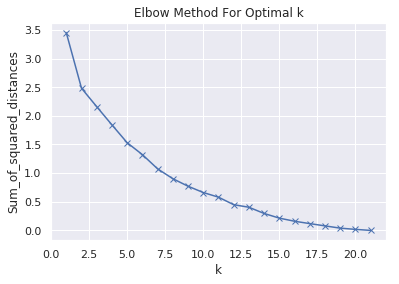

In [23]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()
#Sum_of_squared_distances

Let's then take k = 8.

In [24]:
# set number of clusters
kclusters = 8

# miami_grouped_clustering = miami_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(miami_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 0, 0, 0, 5, 0, 0, 0, 0, 4], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [25]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

miami_merged = miamidf

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
miami_merged = miami_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

miami_merged = miami_merged.join(miami_grouped['Coffee Shop'])
miami_merged.head()

/home/usuario/.local/lib/python2.7/site-packages/pandas/core/indexes/base.py:2755: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  indexer = self._engine.get_indexer(target._ndarray_values)


,Neighborhood,Population (2010),Population per Km²,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Coffee Shop
0,Allapattah,54289,4401,25.815,-80.224,2,Convenience Store,Department Store,Lounge,Donut Shop,Flea Market,Fish Market,Fast Food Restaurant,Event Space,Empanada Restaurant,Dog Run,0.000000
1,Arts & Entertainment District,11033,7948,25.799,-80.190,0,Restaurant,Gym,Spa,Ice Cream Shop,Moving Target,Cupcake Shop,Paper / Office Supplies Store,Park,Gym / Fitness Center,Pizza Place,0.000000
2,Brickell,31759,14541,25.758,-80.193,0,Hotel,Italian Restaurant,Japanese Restaurant,Café,Restaurant,Bank,Juice Bar,Park,Seafood Restaurant,Argentinian Restaurant,0.000000
3,Buena Vista,9058,3540,25.813,-80.192,0,Boutique,Café,Jewelry Store,Italian Restaurant,Bakery,Fast Food Restaurant,Coffee Shop,Clothing Store,Mediterranean Restaurant,Leather Goods Store,0.037037
4,Coconut Grove,20076,3091,25.712,-80.257,5,American Restaurant,Park,Boat or Ferry,Wings Joint,Donut Shop,Flea Market,Fish Market,Fast Food Restaurant,Event Space,Empanada Restaurant,0.000000


Finally, let's visualize the resulting clusters

In [26]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(miami_merged['Latitude'], miami_merged['Longitude'], miami_merged['Neighborhood'], miami_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Clusters Examination  <a name="examine"></a>

Now, we can examine each cluster and determine the discriminating venue categories that distinguish each cluster.

#### Cluster 1

In [27]:
cldf1=miami_merged.loc[miami_merged['Cluster Labels'] == 0, miami_merged.columns[[0,1,2] + list(range(6, miami_merged.shape[1]))]]
cldf1

,Neighborhood,Population (2010),Population per Km²,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Coffee Shop
1,Arts & Entertainment District,11033,7948,Restaurant,Gym,Spa,Ice Cream Shop,Moving Target,Cupcake Shop,Paper / Office Supplies Store,Park,Gym / Fitness Center,Pizza Place,0.000000
2,Brickell,31759,14541,Hotel,Italian Restaurant,Japanese Restaurant,Café,Restaurant,Bank,Juice Bar,Park,Seafood Restaurant,Argentinian Restaurant,0.000000
3,Buena Vista,9058,3540,Boutique,Café,Jewelry Store,Italian Restaurant,Bakery,Fast Food Restaurant,Coffee Shop,Clothing Store,Mediterranean Restaurant,Leather Goods Store,0.037037
5,Coral Way,35062,4496,Liquor Store,Pharmacy,Golf Course,Seafood Restaurant,Burger Joint,Café,Mobile Phone Shop,Dive Bar,Historic Site,Diner,0.000000
6,Design District,3573,3623,Boutique,Café,Jewelry Store,Italian Restaurant,Bakery,Fast Food Restaurant,Coffee Shop,Clothing Store,Mediterranean Restaurant,Leather Goods Store,0.037037
7,Downtown,71000,10613,Peruvian Restaurant,Hotel,Italian Restaurant,Brazilian Restaurant,Café,Pharmacy,Cosmetics Shop,Coffee Shop,Pet Service,Cocktail Bar,0.046512
8,Edgewater,15005,6675,Restaurant,Sandwich Place,Breakfast Spot,Pizza Place,Peruvian Restaurant,Gym,Gym / Fitness Center,French Restaurant,Cuban Restaurant,Art Gallery,0.020833
10,Grapeland Heights,14004,4130,Hotel Pool,Auto Garage,Gym / Fitness Center,Gym,Golf Course,Hotel Bar,Restaurant,Bus Station,Bar,Hotel,0.000000
12,Little Haiti,29760,3840,Yoga Studio,Coffee Shop,Pub,Caribbean Restaurant,Pizza Place,Gym,Pharmacy,Clothing Store,Dance Studio,Shopping Mall,0.043478
16,Park West,4655,3635,Nightclub,Café,Lounge,Theater,Bar,Pizza Place,Gastropub,Event Space,Flea Market,Performing Arts Venue,0.035714


#### Cluster 2

In [28]:
miami_merged.loc[miami_merged['Cluster Labels'] == 1, miami_merged.columns[[0,1,2] + list(range(6, miami_merged.shape[1]))]]

,Neighborhood,Population (2010),Population per Km²,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Coffee Shop
19,Virginia Key,14,-,Beach,Wings Joint,Food Truck,Flea Market,Fish Market,Fast Food Restaurant,Event Space,Empanada Restaurant,Donut Shop,Dog Run,0.0


#### Cluster 3

In [29]:
miami_merged.loc[miami_merged['Cluster Labels'] == 2, miami_merged.columns[[0,1,2] + list(range(6, miami_merged.shape[1]))]]

,Neighborhood,Population (2010),Population per Km²,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Coffee Shop
0,Allapattah,54289,4401,Convenience Store,Department Store,Lounge,Donut Shop,Flea Market,Fish Market,Fast Food Restaurant,Event Space,Empanada Restaurant,Dog Run,0.0


#### Cluster 4

In [30]:
miami_merged.loc[miami_merged['Cluster Labels'] == 3, miami_merged.columns[[0,1,2] + list(range(6, miami_merged.shape[1]))]]

,Neighborhood,Population (2010),Population per Km²,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Coffee Shop
11,Liberty City,19725,3733,Food,Southern / Soul Food Restaurant,Bar,Donut Shop,Flea Market,Fish Market,Fast Food Restaurant,Event Space,Empanada Restaurant,Wings Joint,0.0


#### Cluster 5

In [31]:
miami_merged.loc[miami_merged['Cluster Labels'] == 4, miami_merged.columns[[0,1,2] + list(range(6, miami_merged.shape[1]))]]

,Neighborhood,Population (2010),Population per Km²,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Coffee Shop
9,Flagami,50834,5665,Seafood Restaurant,Cuban Restaurant,Pet Store,Fast Food Restaurant,Department Store,Spanish Restaurant,Bakery,Donut Shop,Event Space,Empanada Restaurant,0.0
14,Lummus Park,3027,3680,Seafood Restaurant,Fish Market,Hotel,BBQ Joint,American Restaurant,Soccer Field,Restaurant,Spanish Restaurant,Fast Food Restaurant,Event Space,0.0


#### Cluster 6

In [32]:
cldf6=miami_merged.loc[miami_merged['Cluster Labels'] == 5, miami_merged.columns[[0,1,2] + list(range(6, miami_merged.shape[1]))]]
cldf6

,Neighborhood,Population (2010),Population per Km²,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Coffee Shop
4,Coconut Grove,20076,3091,American Restaurant,Park,Boat or Ferry,Wings Joint,Donut Shop,Flea Market,Fish Market,Fast Food Restaurant,Event Space,Empanada Restaurant,0.0


#### Cluster 7

In [33]:
miami_merged.loc[miami_merged['Cluster Labels'] == 6, miami_merged.columns[[0,1,2] + list(range(6, miami_merged.shape[1]))]]

,Neighborhood,Population (2010),Population per Km²,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Coffee Shop
15,Overtown,6736,3405,Wings Joint,Athletics & Sports,Pool,Southern / Soul Food Restaurant,Fast Food Restaurant,Event Space,Empanada Restaurant,Donut Shop,Dog Run,Dive Bar,0.0


#### Cluster 8

In [34]:
miami_merged.loc[miami_merged['Cluster Labels'] == 7, miami_merged.columns[[0,1,2] + list(range(6, miami_merged.shape[1]))]]

,Neighborhood,Population (2010),Population per Km²,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Coffee Shop
13,Little Havana,76163,8423,Latin American Restaurant,Discount Store,Pharmacy,Shoe Store,Grocery Store,Mexican Restaurant,Fast Food Restaurant,Event Space,Empanada Restaurant,Donut Shop,0.0


Finally, we make a bubble plot from the clusters, where the bubble size is given by the coffee shop frequency

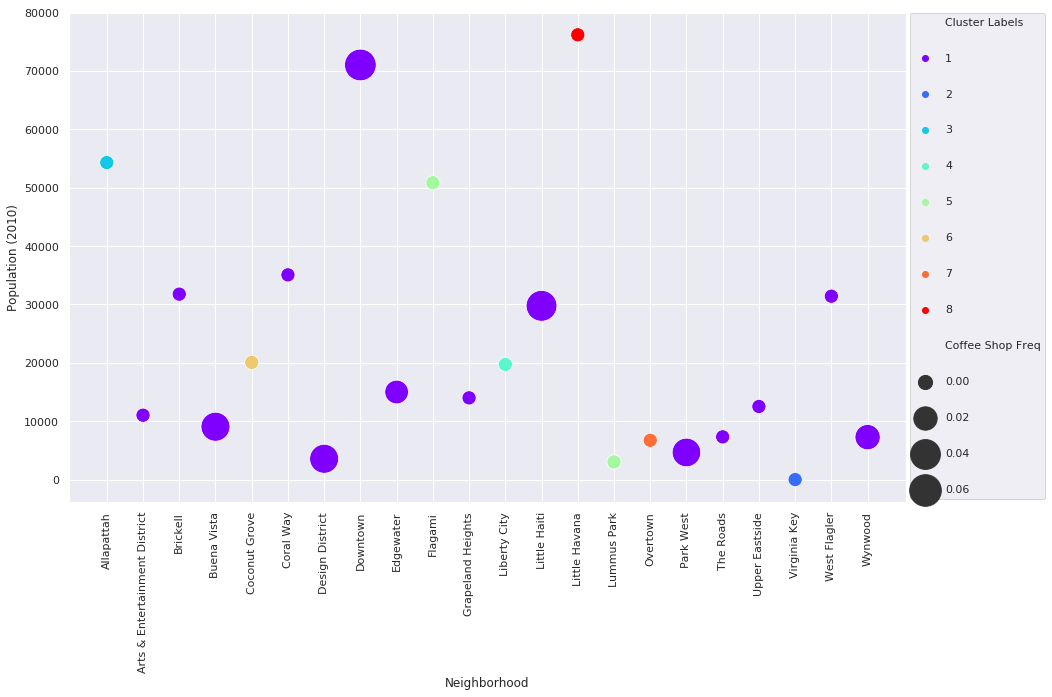

In [35]:
bubplot = miami_merged.copy()
bubplot['Cluster Labels'] = bubplot['Cluster Labels'] + 1
bubplot['Population (2010)'] = bubplot['Population (2010)'].astype(int)
bubplot = bubplot.rename(columns = {'Coffee Shop':'Coffee Shop Freq'})

tips = sns.load_dataset("tips")
sns.set(rc={'figure.figsize':(15,9)})
# cmap = sns.palplot(sns.color_palette())
# cmap = sns.color_palette("Set1", n_colors=8, desat=1)
# cmap = sns.color_palette("muted")
cmap = rainbow

ax = sns.scatterplot(x= bubplot['Neighborhood'],
                     y=bubplot['Population (2010)'],
                     size=bubplot['Coffee Shop Freq'],
                     hue=bubplot['Cluster Labels'],
                     sizes=(200, 1000),
                     palette=cmap,
                     data=tips)

plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.005, 1), loc=2, borderaxespad=0.,labelspacing=2.36)

## Results and Discussion <a name="results"></a>

Through Foursquare, we have explored the venues in each Miami's neighborhood. From this information we have used the elbow method and classified them in 8 different clusters. Through the observation of the most common venues in each cluster we can see that a Coffee Shop is not in the top five venues for any neighborhood. Except for Little Haiti (pop. 29760) where it is the second most common venue.

The five most populated neighborhoods are in cluster 8 Little Havana (pop. 76163), in cluster 1 Downtown (pop. 71000), in cluster 3 Allapattah (pop. 54289), in cluster 4 Flagami (pop. 50834),  and finally in in cluster 1 we have Coral Way (pop. 35062).

We can see from the last figure that cluster 1 is the one containing all the coffe shops in it. None neighborhood outside cluster 1 has a coffee shop.

We are taking two conditions to set an optimal location for our Coffee Shop. First there have to be no coffee shops in the proximity. Secondly, we are looking for high population zones. From this we can infer that the optimal location for our small, quiet Coffee Shop is Little Havanna, secondly Allapattah, and Flagami is our third option.

A more comprehensive analysis can be made dividind the city in a grid and looking for pockets with low concentration of coffe shops. This can also be complemented with other data, such as total income per zone to give an example

## Conclusion <a name="conclusion"></a>

The purpose of this project was to identify Miami's neighborhoods with low number of coffee shops and high population. It was in order to aid stakeholders in narrowing down the search for optimal location for a new small and quiet coffee shop. By clustering the neighborhoods through their venues from Foursquare data, we have identified general boroughs that justify further analysis (Little Havana, Allapattah and Flagami).

Final decission on optimal restaurant location will be made by stakeholders based on specific characteristics of neighborhoods and locations in every recommended zone, taking into consideration additional factors like attractiveness of each location (proximity to park or water), levels of noise / proximity to major roads, real estate availability, prices, social and economic dynamics of every neighborhood etc.